In [16]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import wordcloud #Makes word clouds

import pandas as pd
import seaborn as sns
#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Prepare the Large Data

In [32]:
now_df = pd.read_table('../data/preprocessed inequality news.txt' ,header=0, encoding='gb2312', sep=',') 
now_df.dropna(inplace=True)

In [33]:
#now_df = now_df.sample(frac = 0.2)
len(now_df)

45429

In [34]:
now_df['tokenized_words'] = now_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
now_df['normalized_words'] = now_df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))


In [35]:
# for word cloud, it is not needed
# tokenized and normalized sentence
now_df['tokenized_sents'] = now_df['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
now_df['normalized_sents'] = now_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
now_df.head()

,id,text,month,year,tokenized_text,normalized_tokens,reduced_tokens,tokenized_words,normalized_words,tokenized_sents,normalized_sents
0,1705816,"For those of us who have not known war , the ...",11,10,"['For', 'those', 'of', 'us', 'who', 'have', 'n...","['know', 'war', 'word', 'soldier', 'help', 'un...","['know', 'war', 'word', 'help', 'understand', ...","[For, those, of, us, who, have, not, known, wa...","[known, war, words, soldiers, help, understand...","[[For, those, of, us, who, have, not, known, w...","[[know, war, word, soldier, help, understand, ..."
1,4512620,"Kazi Khaleed Ashraf ONCE upon a time , Dhak...",3,10,"['Kazi', 'Khaleed', 'Ashraf', 'ONCE', 'upon', ...","['kazi', 'khaleed', 'ashraf', 'time', 'dhaka',...","['city', 'street', 'heart', 'city', 'air', 'se...","[Kazi, Khaleed, Ashraf, ONCE, upon, a, time, D...","[kazi, khaleed, ashraf, time, dhaka, fine, cit...","[[Kazi, Khaleed, Ashraf], [ONCE, upon, a, time...","[[kazi, khaleed, ashraf], [time, dhaka, fine, ..."
2,1448476,There is a myth in wide circulation that the ...,4,10,"['There', 'is', 'a', 'myth', 'in', 'wide', 'ci...","['myth', 'wide', 'circulation', 'superiority',...","['free', 'trade', 'simply', 'question', 'agree...","[There, is, a, myth, in, wide, circulation, th...","[myth, wide, circulation, superiority, free, t...","[[There, is, a, myth, in, wide, circulation, t...","[[myth, wide, circulation, superiority, free, ..."
3,1490802,Please turn on JavaScript . Media requires Ja...,5,10,"['Please', 'turn', 'on', 'JavaScript', 'Media'...","['turn', 'javascript', 'medium', 'require', 'j...","['turn', 'play', 'foreign', 'secretary', 'say'...","[Please, turn, on, JavaScript, Media, requires...","[turn, javascript, media, requires, javascript...","[[Please, turn, on, JavaScript], [Media, requi...","[[turn, javascript], [medium, require, javascr..."
4,1647381,Image caption The death of Mono Jojoy could c...,9,10,"['Image', 'caption', 'The', 'death', 'of', 'Mo...","['image', 'caption', 'death', 'mono', 'jojoy',...","['death', 'cause', 'group', 'military', 'succe...","[Image, caption, The, death, of, Mono, Jojoy, ...","[image, caption, death, mono, jojoy, cause, fr...","[[Image, caption], [The, death, of, Mono, Jojo...","[[image, caption], [death, mono, jojoy, cause,..."


Note: onpy those concerning of nowDF_p1, nowDF_p2, nowDF_p3 need to rerun the code again.  
All processing by topic by year doesn't need to be processed again, beause they are cut from the preprocessed inequality news.txt, and split by topics.

In [36]:
def cut_period(now_df):
    # nowDF1: 2010, 2011, 2012
    nowDF_p1 = now_df[now_df['year']==10]
    nowDF_p1 = nowDF_p1.append(now_df[now_df['year']==11])
    nowDF_p1 = nowDF_p1.append(now_df[now_df['year']==12])
    nowDF_p1 = nowDF_p1.append(now_df[now_df['year']==13])
    # nowDF2: 2013-15
    nowDF_p2 = now_df[now_df['year']==14]
    nowDF_p2 = nowDF_p2.append(now_df[now_df['year']==15])
    nowDF_p2 = nowDF_p2.append(now_df[now_df['year']==16])

    # nowDF3: 2016-19
    nowDF_p3 = now_df[now_df['year']==17]
    nowDF_p3 = nowDF_p3.append(now_df[now_df['year']==18])
    nowDF_p3 = nowDF_p3.append(now_df[now_df['year']==19])
    return nowDF_p1, nowDF_p2, nowDF_p3

In [37]:
nowDF_p1, nowDF_p2, nowDF_p3 = cut_period(now_df)

In [38]:
len(nowDF_p1), len(nowDF_p2), len(nowDF_p3)

(5402, 14494, 25533)

# Word2vec

In [68]:
nowW2V = gensim.models.word2vec.Word2Vec(now_df['normalized_sents'].sum())

In [17]:
numWords = 70
targetWords = nowW2V.wv.index2word[:numWords]
# Matrix
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(nowW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

# PCA to reduce the dimensions
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)


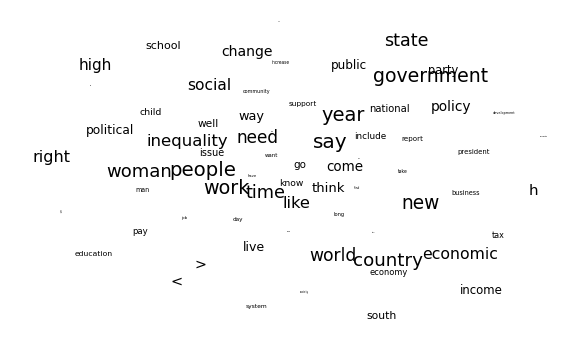

In [18]:
# Plot the points
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

In [50]:
keywords = ['woman','man','work', 'poverty', 'poor','income', 'government', 'economic',\
            'political', 'insurance', 'career', 'health', 'education', 'child',\
            'inequality']


In [51]:
taggedDocs = []
for index, row in now_df.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    #docKeywords.append(row['date'])
    docKeywords.append(row['id']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
now_df['TaggedNews'] = taggedDocs
# Now train a Doc2Vec model
# when changing the keywords, I need to train it again
nowD2V = gensim.models.doc2vec.Doc2Vec(now_df['TaggedNews'], size = 100) #Limiting to 100 dimensions

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Plot

In [52]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nowD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nowD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

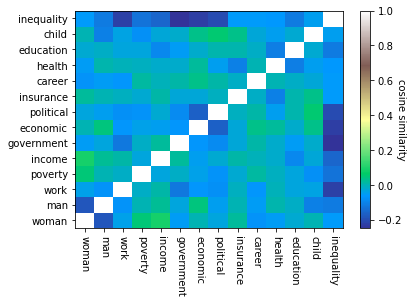

In [53]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

nowDF1

In [260]:
taggedDocs = []
for index, row in nowDF_p1.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    #docKeywords.append(row['date'])
    docKeywords.append(row['id']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
nowDF_p1['TaggedNews'] = taggedDocs
nowD2V_p1 = gensim.models.doc2vec.Doc2Vec(nowDF_p1['TaggedNews'], size = 100) #Limiting to 100 dimensions


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [261]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nowD2V_p1.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nowD2V_p1.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

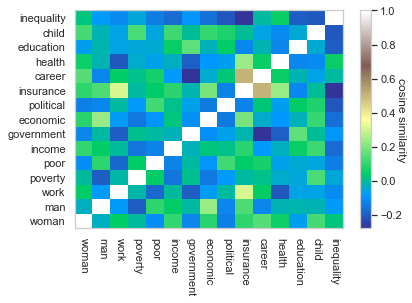

In [262]:
# try
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

DF2

In [263]:
taggedDocs = []
for index, row in nowDF_p2.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    #docKeywords.append(row['date'])
    docKeywords.append(row['id']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
nowDF_p2['TaggedNews'] = taggedDocs
nowD2V_p2 = gensim.models.doc2vec.Doc2Vec(nowDF_p2['TaggedNews'], size = 100) #Limiting to 100 dimensions

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [264]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nowD2V_p2.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nowD2V_p2.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)


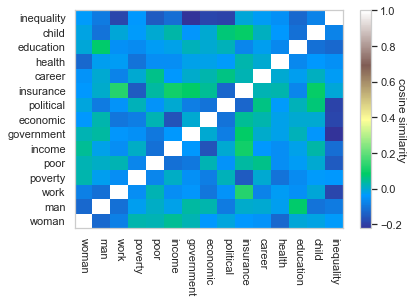

In [265]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

DF3

In [266]:
taggedDocs = []
for index, row in nowDF_p3.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    #docKeywords.append(row['date'])
    docKeywords.append(row['id']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
nowDF_p3['TaggedNews'] = taggedDocs
nowD2V_p3 = gensim.models.doc2vec.Doc2Vec(nowDF_p3['TaggedNews'], size = 100) #Limiting to 100 dimensions


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [267]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nowD2V_p3.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nowD2V_p3.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

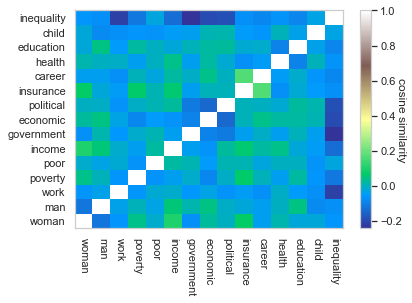

In [268]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

# Projection

In [33]:
tnytTargetWords = ['woman', 'black', 'white', 'poor', 'rich', 'expensive', 'wealthy', 'cheap', 'inexpensive']
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "salad",  "beer", "wine", "pastry", "basketball", "baseball", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nowW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)


In [34]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 30).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

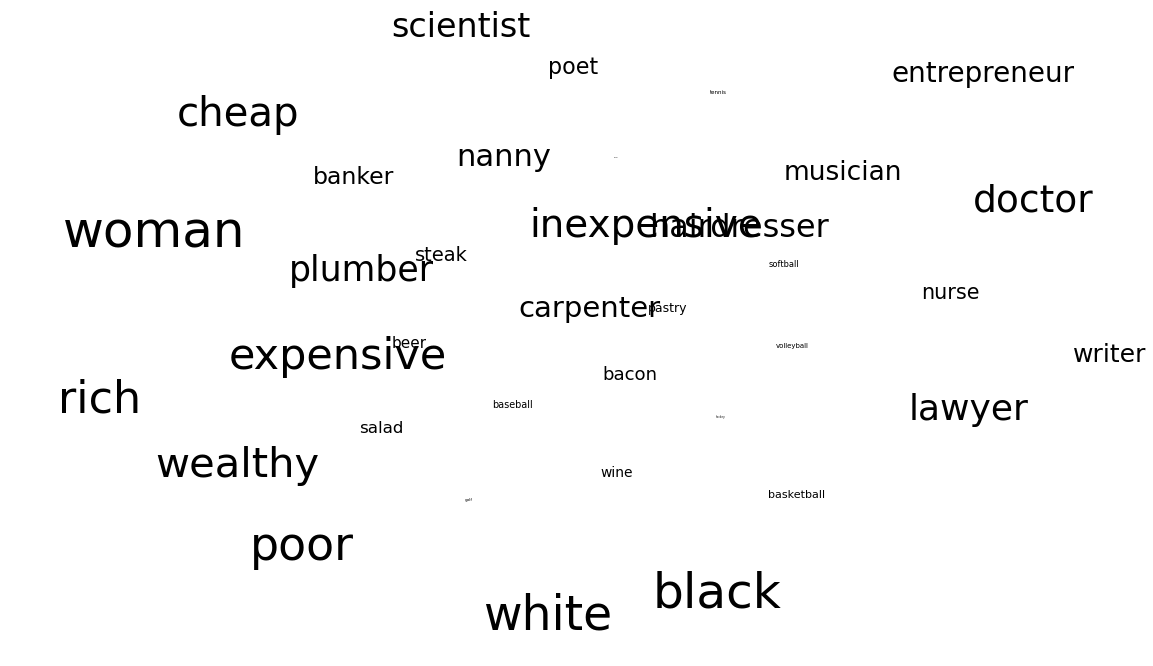

In [35]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [69]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [180]:
Gender = dimension(nowW2V, ['man'], ['woman'])
Race = dimension(nowW2V, ['black'], ['white'])
Class = dimension(nowW2V, ['rich', 'expensive', 'wealthy','affluence'], ['poor','cheap', 'inexpensive','poverty'])
Education = dimension(nowW2V, ['literate'],['illiterate'])
Employ = dimension(nowW2V, ['employer','owner','manager','boss','capitalist'],['employee','worker','staff','worker','proletarian'])


In [181]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon",  "salad",  "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball",  "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

People = ["african", "american", "asian", "indian", "european", "chinese", "japanese","mexican"]


In [182]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    l = []
    e = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nowW2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nowW2V[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nowW2V[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
        l.append(sklearn.metrics.pairwise.cosine_similarity(nowW2V[word].reshape(1,-1), Education.reshape(1,-1))[0][0])
        e.append(sklearn.metrics.pairwise.cosine_similarity(nowW2V[word].reshape(1,-1), Employ.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c, 'education':l, 'employ':e}, index = word_list)
    return df

In [183]:
OCCdf = makeDF(nowW2V, Occupations) 
Fooddf = makeDF(nowW2V, Foods)
Sportsdf = makeDF(nowW2V, Sports)
Peopledf = makeDF(nowW2V, People)

In [184]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

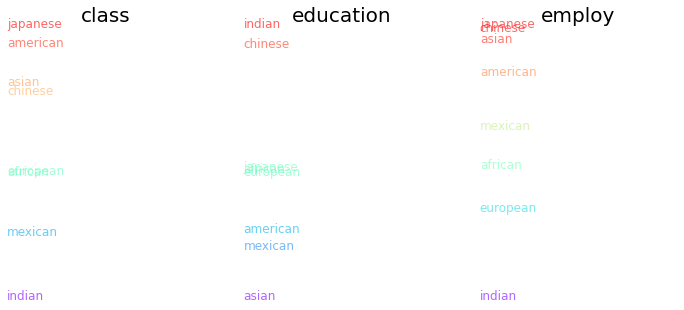

In [185]:
fig = plt.figure(figsize = (12,5))

#ax1 = fig.add_subplot(131)
#PlotDimension(ax1, Peopledf, 'gender')
#ax2 = fig.add_subplot(131)
#PlotDimension(ax2, Peopledf, 'race')
ax3 = fig.add_subplot(131)
PlotDimension(ax3, Peopledf, 'class')
ax4 = fig.add_subplot(132)
PlotDimension(ax4, Peopledf, 'education')
ax5 = fig.add_subplot(133)
PlotDimension(ax5, Peopledf, 'employ')
plt.show()

# For topics

In [39]:
def Word2Vec(nowDF0, name):
    nowW2V0 = gensim.models.word2vec.Word2Vec(nowDF0['normalized_sents'].sum())
    
    numWords = 70
    targetWords = nowW2V0.wv.index2word[:numWords]
    # Matrix
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(nowW2V0[word])
    wordsSubMatrix = np.array(wordsSubMatrix)

    # PCA to reduce the dimensions
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    
    # Plot the points
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    fig.savefig("w2vec_{df}.jpg".format(df=name))

In [40]:
def Doc2Vec(nowDF0, name, keywords):
    taggedDocs = []
    for index, row in nowDF0.iterrows():
        docKeywords = [s for s in keywords if s in row['normalized_tokens']]
        #docKeywords.append(row['date'])
        docKeywords.append(row['id']) #This lets us extract individual documnets since doi's are unique
        taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
    nowDF0['TaggedNews'] = taggedDocs
    # Now train a Doc2Vec model
    # when changing the keywords, I need to train it again
    nowD2V0 = gensim.models.doc2vec.Doc2Vec(nowDF0['TaggedNews'], size = 100) #Limiting to 100 dimensions
    
    heatmapMatrix = []
    for tagOuter in keywords:
        column = []
        tagVec = nowD2V0.docvecs[tagOuter].reshape(1, -1)
        for tagInner in keywords:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nowD2V0.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    heatmapMatrix = np.array(heatmapMatrix)

    fig, ax = plt.subplots()
    hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
    cbar = plt.colorbar(hmap)

    cbar.set_label('cosine similarity', rotation=270)
    a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
    a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

    a = ax.set_xticklabels(keywords, minor=False, rotation=270)
    a = ax.set_yticklabels(keywords, minor=False)
    fig.savefig("doc2vec_{df}.jpg".format(df=name))

In [41]:
def tokenize_normalize_sents(topic_name):
    nowDF0 = pd.read_table('../data/inequality_topic/'+ topic_name + '_text.csv' ,header=0, encoding='gb2312', sep=',') 
    nowDF0.dropna(inplace=True)
    # tokenized and normalized sentence
    nowDF0['tokenized_sents'] = nowDF0['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
    nowDF0['normalized_sents'] = nowDF0['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
    nowDF0.head()
    return nowDF0

## Topic 0

In [42]:
nowDF0 = pd.read_table('../data/inequality_topic/topic0_text.csv' ,header=0, encoding='gb2312', sep=',') 
nowDF0.dropna(inplace=True)

In [93]:
nowDF0.head()

,Unnamed: 0,id,text,month,year,tokenized_text,normalized_tokens,reduced_tokens
0,3,1490802,Please turn on JavaScript . Media requires Ja...,5,10,"['Please', 'turn', 'on', 'JavaScript', 'Media'...","['turn', 'javascript', 'medium', 'require', 'j...","['turn', 'play', 'foreign', 'secretary', 'say'..."
1,11,1367433,I 've been spending the wee small hours of Mo...,1,10,"['I', 've', 'been', 'spending', 'the', 'wee', ...","['have', 'spend', 'wee', 'small', 'hour', 'mon...","['spend', 'small', 'read', 'economic', 'report..."
2,15,1344524,Sir John Cass Redcoat Church of England Secon...,1,10,"['Sir', 'John', 'Cass', 'Redcoat', 'Church', '...","['sir', 'john', 'cass', 'redcoat', 'church', '...","['john', 'church', 'school', 'council', 'east'..."
3,18,1666501,"The "" coping classes "" increasingly are strug...",10,10,"['The', 'coping', 'classes', 'increasingly', '...","['cope', 'class', 'increasingly', 'struggle', ...","['class', 'increasingly', 'struggle', 'respons..."
4,21,1551191,Daniel W. Drezner is professor of internation...,7,10,"['Daniel', 'W.', 'Drezner', 'is', 'professor',...","['daniel', 'w.', 'drezner', 'professor', 'inte...","['professor', 'international', 'school', 'law'..."


In [95]:
len(nowDF0)

11052

In [43]:
# tokenized and normalized sentence
nowDF0['tokenized_sents'] = nowDF0['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
nowDF0['normalized_sents'] = nowDF0['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
nowDF0.head()


,Unnamed: 0,id,text,month,year,tokenized_text,normalized_tokens,reduced_tokens,tokenized_sents,normalized_sents
0,3,1490802,Please turn on JavaScript . Media requires Ja...,5,10,"['Please', 'turn', 'on', 'JavaScript', 'Media'...","['turn', 'javascript', 'medium', 'require', 'j...","['turn', 'play', 'foreign', 'secretary', 'say'...","[[Please, turn, on, JavaScript], [Media, requi...","[[turn, javascript], [medium, require, javascr..."
1,11,1367433,I 've been spending the wee small hours of Mo...,1,10,"['I', 've', 'been', 'spending', 'the', 'wee', ...","['have', 'spend', 'wee', 'small', 'hour', 'mon...","['spend', 'small', 'read', 'economic', 'report...","[[I, ve, been, spending, the, wee, small, hour...","[[have, spend, wee, small, hour, monday, morni..."
2,15,1344524,Sir John Cass Redcoat Church of England Secon...,1,10,"['Sir', 'John', 'Cass', 'Redcoat', 'Church', '...","['sir', 'john', 'cass', 'redcoat', 'church', '...","['john', 'church', 'school', 'council', 'east'...","[[Sir, John, Cass, Redcoat, Church, of, Englan...","[[sir, john, cass, redcoat, church, england, s..."
3,18,1666501,"The "" coping classes "" increasingly are strug...",10,10,"['The', 'coping', 'classes', 'increasingly', '...","['cope', 'class', 'increasingly', 'struggle', ...","['class', 'increasingly', 'struggle', 'respons...","[[The, coping, classes, increasingly, are, str...","[[cope, class, increasingly, struggle, respons..."
4,21,1551191,Daniel W. Drezner is professor of internation...,7,10,"['Daniel', 'W.', 'Drezner', 'is', 'professor',...","['daniel', 'w.', 'drezner', 'professor', 'inte...","['professor', 'international', 'school', 'law'...","[[Daniel, W., Drezner, is, professor, of, inte...","[[daniel, w., drezner, professor, internationa..."


Topic2

In [ ]:
nowDF2 = pd.read_table('../data/inequality_topic/topic1_text.csv' ,header=0, encoding='gb2312', sep=',') 
nowDF2.dropna(inplace=True)

In [109]:
# tokenized and normalized sentence
nowDF2['tokenized_sents'] = nowDF2['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
nowDF2['normalized_sents'] = nowDF2['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
nowDF2.head()


,Unnamed: 0,id,text,month,year,tokenized_text,normalized_tokens,reduced_tokens,tokenized_sents,normalized_sents
0,3,1490802,Please turn on JavaScript . Media requires Ja...,5,10,"['Please', 'turn', 'on', 'JavaScript', 'Media'...","['turn', 'javascript', 'medium', 'require', 'j...","['turn', 'play', 'foreign', 'secretary', 'say'...","[[Please, turn, on, JavaScript], [Media, requi...","[[turn, javascript], [medium, require, javascr..."
1,4,1647381,Image caption The death of Mono Jojoy could c...,9,10,"['Image', 'caption', 'The', 'death', 'of', 'Mo...","['image', 'caption', 'death', 'mono', 'jojoy',...","['death', 'cause', 'group', 'military', 'succe...","[[Image, caption], [The, death, of, Mono, Jojo...","[[image, caption], [death, mono, jojoy, cause,..."
2,9,4513686,Staff Correspondent Another fire broke out ...,4,10,"['Staff', 'Correspondent', 'Another', 'fire', ...","['staff', 'correspondent', 'fire', 'break', 'g...","['staff', 'half', 'month', 'leave', 'death', '...","[[Staff, Correspondent], [Another, fire, broke...","[[staff, correspondent], [fire, break, garib, ..."
3,14,1441822,"On his April 7 show , Glenn Beck deceptively ...",4,10,"['On', 'his', 'April', '7', 'show', 'Glenn', '...","['april', 'glenn', 'beck', 'deceptively', 'cro...","['april', 'speech', 'house', 'order', 'say', '...","[[On, his, April, 7, show, Glenn, Beck, decept...","[[april, glenn, beck, deceptively, crop, speec..."
4,16,1609564,Some fellow named W.W. at the Economist is sk...,8,10,"['Some', 'fellow', 'named', 'W.W.', 'at', 'the...","['fellow', 'name', 'w.w', 'economist', 'skepti...","['idea', 'rise', 'income', 'recent', 'financia...","[[Some, fellow, named, W.W., at, the, Economis...","[[fellow, name, w.w, economist, skeptical, ide..."


Plot

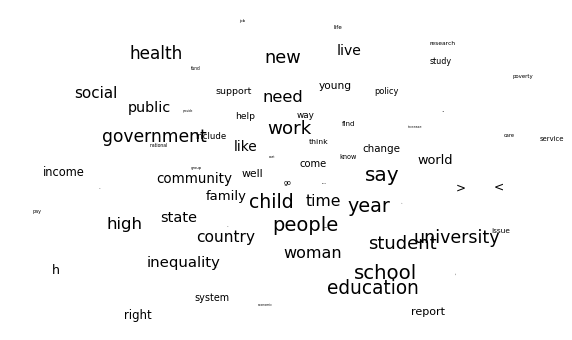

In [162]:
Word2Vec(nowDF0, 'topic0')

### topic0 Education Doc2vec by topic and years

In [44]:
nowDF0_p1 = cut_period(nowDF0)[0]
nowDF0_p2 = cut_period(nowDF0)[1]
nowDF0_p3 = cut_period(nowDF0)[2]
keywords0=['inequality','school','child','education','university','health','work','community','fund','research','race', 'black','asian']


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


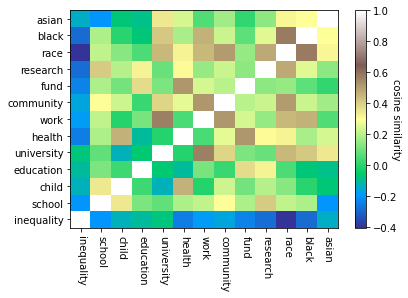

In [45]:
Doc2Vec(nowDF0, 'topic0', keywords0)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


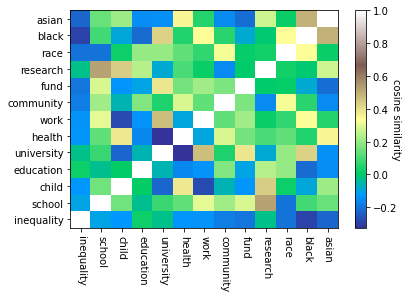

In [46]:
Doc2Vec(nowDF0_p1, 'topic0_p1', keywords0)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


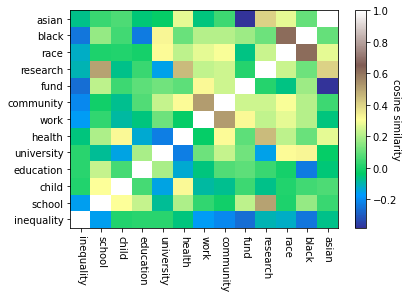

In [47]:
Doc2Vec(nowDF0_p2, 'topic0_p2', keywords0)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


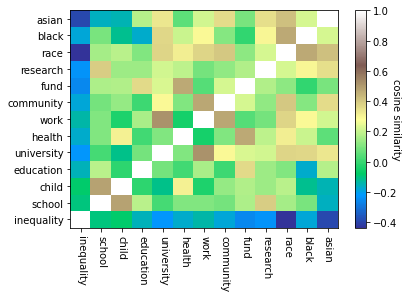

In [48]:
Doc2Vec(nowDF0_p3, 'topic0_p3', keywords0)


## Topic 1

In [49]:
nowDF1 = pd.read_table('../data/inequality_topic/topic1_text.csv' ,header=0, encoding='gb2312', sep=',') 
nowDF1.dropna(inplace=True)

In [50]:
# tokenized and normalized sentence
nowDF1['tokenized_sents'] = nowDF1['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
nowDF1['normalized_sents'] = nowDF1['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
nowDF1.head()


,Unnamed: 0,id,text,month,year,tokenized_text,normalized_tokens,reduced_tokens,tokenized_sents,normalized_sents
0,3,1490802,Please turn on JavaScript . Media requires Ja...,5,10,"['Please', 'turn', 'on', 'JavaScript', 'Media'...","['turn', 'javascript', 'medium', 'require', 'j...","['turn', 'play', 'foreign', 'secretary', 'say'...","[[Please, turn, on, JavaScript], [Media, requi...","[[turn, javascript], [medium, require, javascr..."
1,4,1647381,Image caption The death of Mono Jojoy could c...,9,10,"['Image', 'caption', 'The', 'death', 'of', 'Mo...","['image', 'caption', 'death', 'mono', 'jojoy',...","['death', 'cause', 'group', 'military', 'succe...","[[Image, caption], [The, death, of, Mono, Jojo...","[[image, caption], [death, mono, jojoy, cause,..."
2,9,4513686,Staff Correspondent Another fire broke out ...,4,10,"['Staff', 'Correspondent', 'Another', 'fire', ...","['staff', 'correspondent', 'fire', 'break', 'g...","['staff', 'half', 'month', 'leave', 'death', '...","[[Staff, Correspondent], [Another, fire, broke...","[[staff, correspondent], [fire, break, garib, ..."
3,14,1441822,"On his April 7 show , Glenn Beck deceptively ...",4,10,"['On', 'his', 'April', '7', 'show', 'Glenn', '...","['april', 'glenn', 'beck', 'deceptively', 'cro...","['april', 'speech', 'house', 'order', 'say', '...","[[On, his, April, 7, show, Glenn, Beck, decept...","[[april, glenn, beck, deceptively, crop, speec..."
4,16,1609564,Some fellow named W.W. at the Economist is sk...,8,10,"['Some', 'fellow', 'named', 'W.W.', 'at', 'the...","['fellow', 'name', 'w.w', 'economist', 'skepti...","['idea', 'rise', 'income', 'recent', 'financia...","[[Some, fellow, named, W.W., at, the, Economis...","[[fellow, name, w.w, economist, skeptical, ide..."


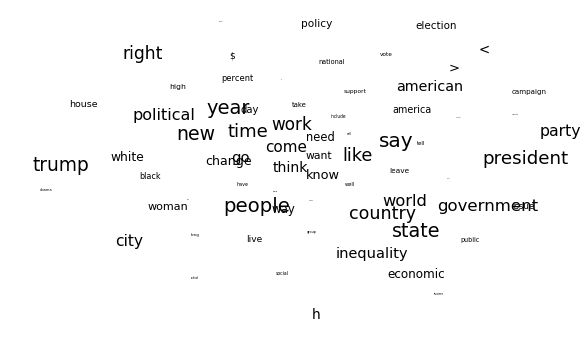

In [127]:
Word2Vec(nowDF1)

In [301]:
# Doc2Vec
Doc2Vec(nowDF1, keywords)

TypeError: Doc2Vec() missing 1 required positional argument: 'keywords'

## Topic2-9 word2vec

In [52]:
nowDF2=tokenize_normalize_sents('topic2')

In [53]:
nowDF3=tokenize_normalize_sents('topic3')

In [54]:
nowDF4=tokenize_normalize_sents('topic4')

In [55]:
nowDF5=tokenize_normalize_sents('topic5')

KeyboardInterrupt: 

In [ ]:
nowDF6=tokenize_normalize_sents('topic6')

In [ ]:
nowDF7=tokenize_normalize_sents('topic7')

In [ ]:
nowDF8=tokenize_normalize_sents('topic8')

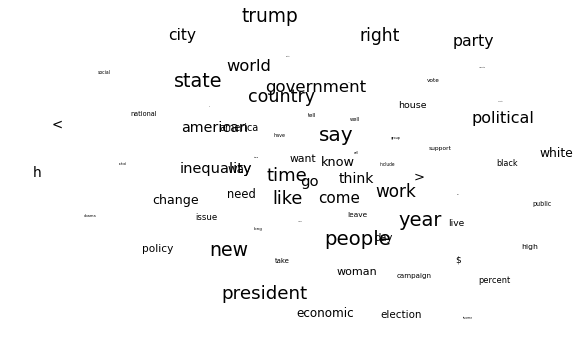

In [163]:
Word2Vec(nowDF1, 'topic1')

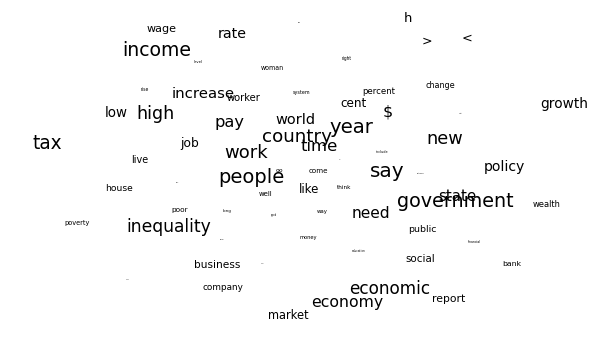

In [164]:
Word2Vec(nowDF2, 'topic2')

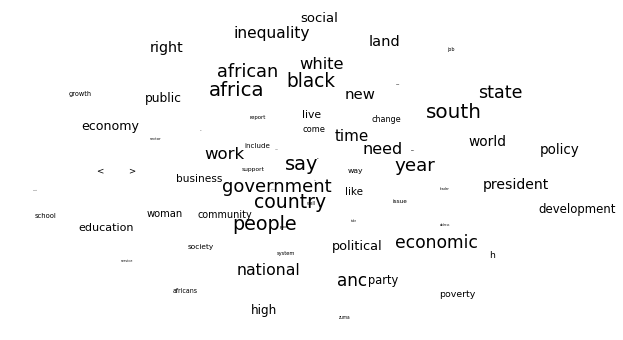

In [165]:
Word2Vec(nowDF3, 'topic3')

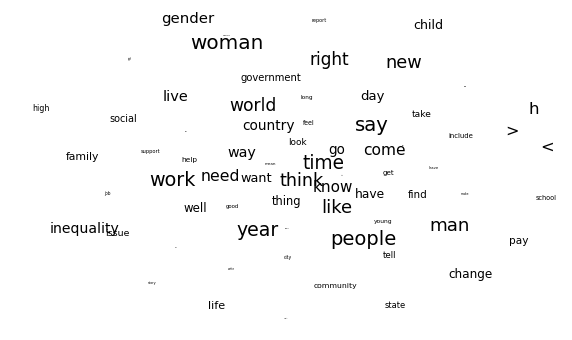

In [166]:
Word2Vec(nowDF4, 'topic4')

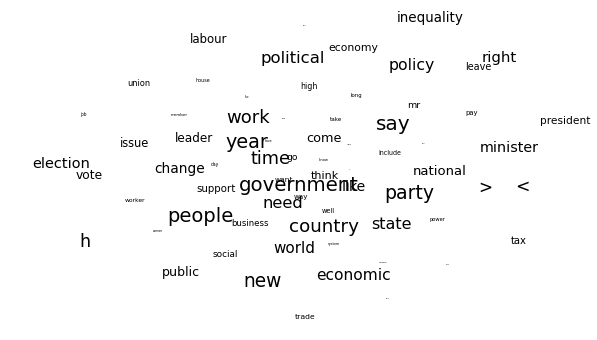

In [167]:
Word2Vec(nowDF5, 'topic5')

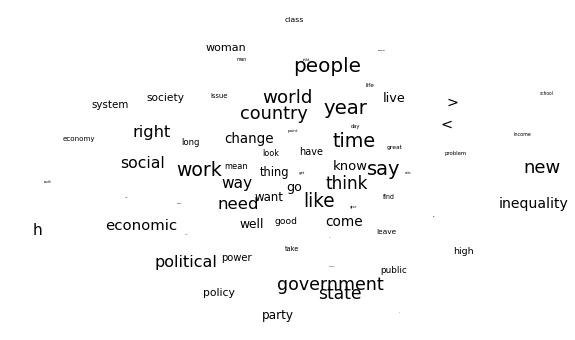

In [168]:
Word2Vec(nowDF6, 'topic6')

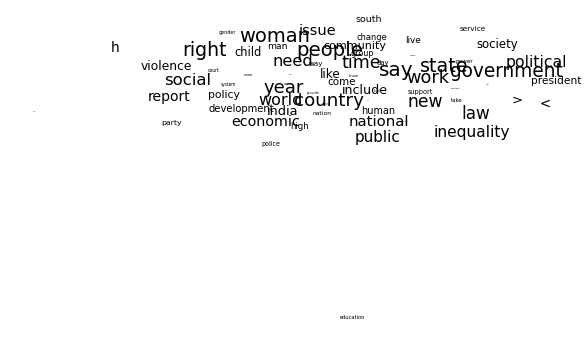

In [177]:
Word2Vec(nowDF7, 'topic7')

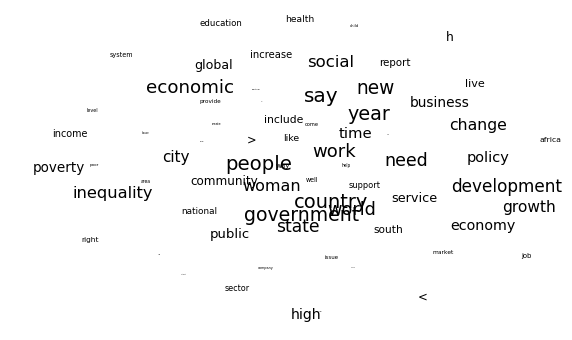

In [178]:
Word2Vec(nowDF8, 'topic8')

## topic1 doc2vec by years

In [51]:
nowDF1_p1 = cut_period(nowDF1)[0]
nowDF1_p2 = cut_period(nowDF1)[1]
nowDF1_p3 = cut_period(nowDF1)[2]

In [296]:
keywords1=['inequality','trump','president','state','american','candidate','campaign','democratic','white',\
          'election','vote','right','policy','labour','work']

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


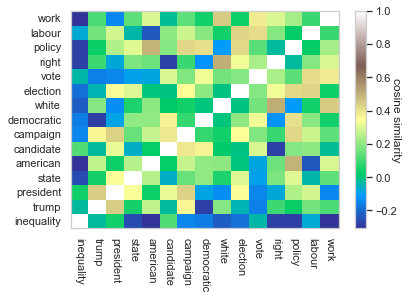

In [297]:
Doc2Vec(nowDF1, 'topic1', keywords1)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


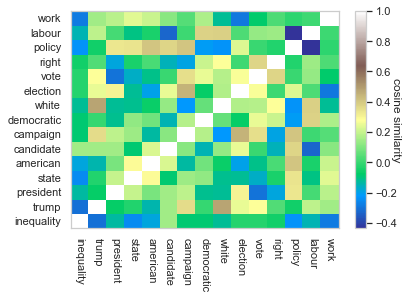

In [298]:
Doc2Vec(nowDF1_p1, 'topic1_p1', keywords1)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


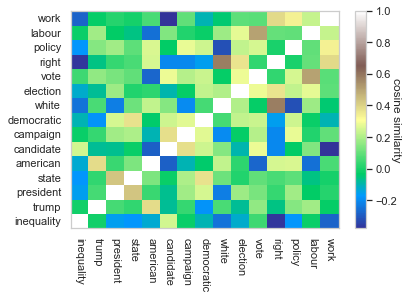

In [299]:
Doc2Vec(nowDF1_p2, 'topic1_p2', keywords1)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


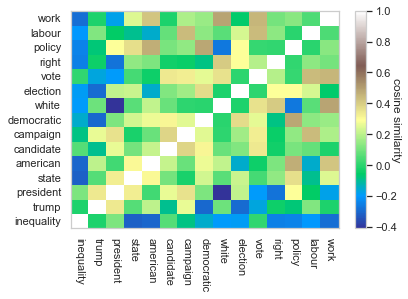

In [300]:
Doc2Vec(nowDF1_p3, 'topic1_p3', keywords1)


## topic8

In [341]:
nowDF2_p1 = cut_period(nowDF2)[0]
nowDF2_p2 = cut_period(nowDF2)[1]
nowDF2_p3 = cut_period(nowDF2)[2]

In [342]:
keywords2=['inequality','tax','income','pay','rate','wage','salary',\
           'bank','economy','market','financial','price','investment','budget']

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


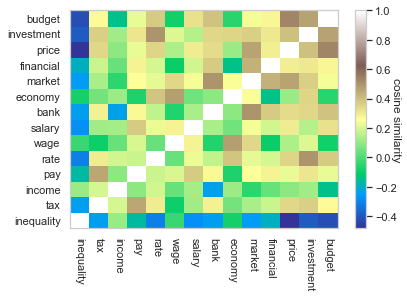

In [343]:
Doc2Vec(nowDF2, 'topic2', keywords2)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


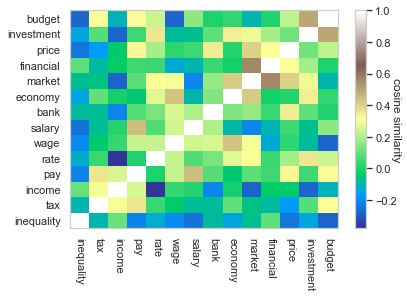

In [344]:
Doc2Vec(nowDF2_p1, 'topic2_p1', keywords2)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


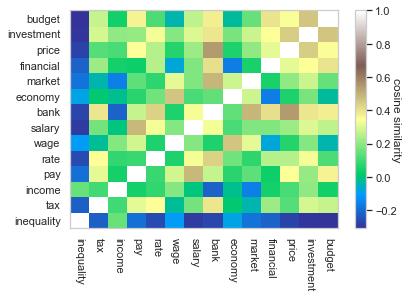

In [345]:
Doc2Vec(nowDF2_p2, 'topic2_p2', keywords2)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


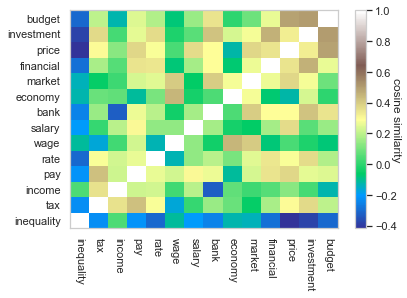

In [346]:
Doc2Vec(nowDF2_p3, 'topic2_p3', keywords2)


## topic3

In [303]:
nowDF3_p1 = cut_period(nowDF3)[0]
nowDF3_p2 = cut_period(nowDF3)[1]
nowDF3_p3 = cut_period(nowDF3)[2]

In [324]:
keywords3=['inequality','south','africa','african','rate','wage','salary',\
           'bank','economy','market','financial','price','investment','budget']


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


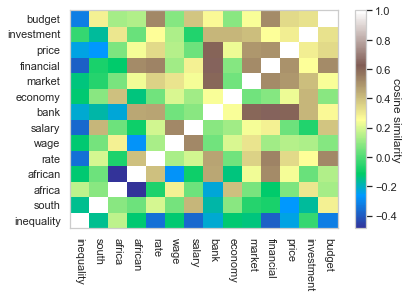

In [325]:
Doc2Vec(nowDF3, 'topic3', keywords3)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


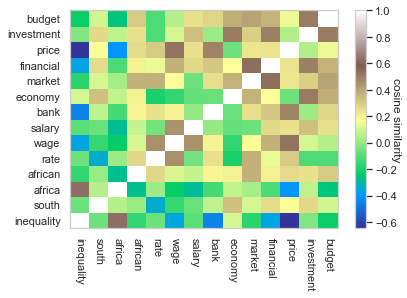

In [326]:
Doc2Vec(nowDF3_p1, 'topic3_p1', keywords3)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


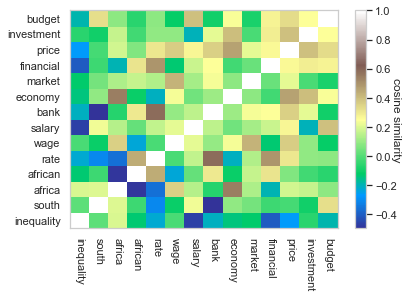

In [327]:
Doc2Vec(nowDF3_p2, 'topic3_p2', keywords3)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


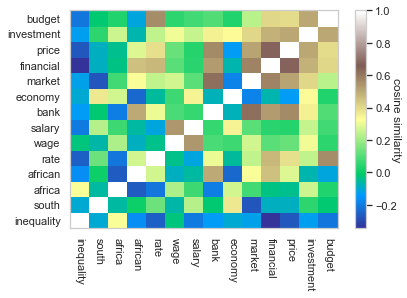

In [328]:
Doc2Vec(nowDF3_p3, 'topic3_p3', keywords3)


## topic4

In [195]:
nowDF4_p1 = cut_period(nowDF4)[0]
nowDF4_p2 = cut_period(nowDF4)[1]
nowDF4_p3 = cut_period(nowDF4)[2]

In [330]:
keywords4=['inequality','woman','man','work','family','child','violence','need','experience',\
          'help','social','sexual']



/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


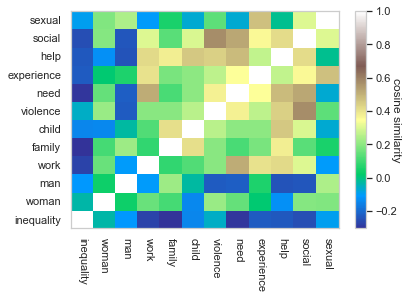

In [331]:
Doc2Vec(nowDF4, 'topic4', keywords4)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


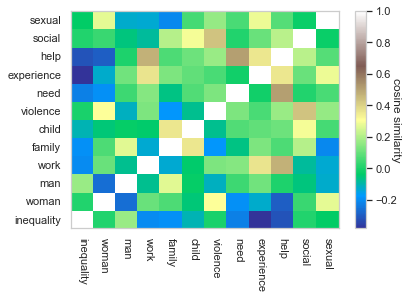

In [332]:
Doc2Vec(nowDF4_p1, 'topic4_p1', keywords4)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


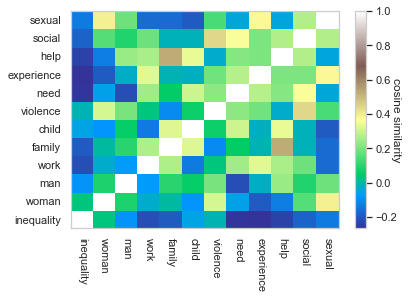

In [333]:
Doc2Vec(nowDF4_p2, 'topic4_p2', keywords4)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


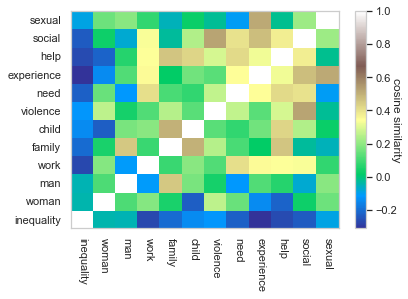

In [334]:
Doc2Vec(nowDF4_p3, 'topic4_p3', keywords4)


## topic5

In [ ]:
nowDF5_p1 = cut_period(nowDF5)[0]
nowDF5_p2 = cut_period(nowDF5)[1]
nowDF5_p3 = cut_period(nowDF5)[2]

In [ ]:
keywords5=['inequality','trump','president','state','american','candidate','campaign','democratic','white']


In [ ]:
Doc2Vec(nowDF5, 'topic5', keywords5)

In [ ]:
Doc2Vec(nowDF5_p1, 'topic5_p1', keywords5)


In [ ]:
Doc2Vec(nowDF5_p2, 'topic5_p2', keywords5)


In [ ]:
Doc2Vec(nowDF5_p3, 'topic5_p3', keywords5)


## topic

In [290]:
nowDF1_p1 = cut_period(nowDF1)[0]
nowDF1_p2 = cut_period(nowDF1)[1]
nowDF1_p3 = cut_period(nowDF1)[2]

In [291]:
keywords1=['inequality','trump','president','state','american','candidate','campaign','democratic','white']

In [ ]:
Doc2Vec(nowDF1, 'topic1', keywords1)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
Doc2Vec(nowDF1_p1, 'topic1_p1', keywords1)


In [ ]:
Doc2Vec(nowDF1_p2, 'topic1_p2', keywords1)


In [ ]:
Doc2Vec(nowDF1_p3, 'topic1_p3', keywords1)


## topic2

In [290]:
nowDF1_p1 = cut_period(nowDF1)[0]
nowDF1_p2 = cut_period(nowDF1)[1]
nowDF1_p3 = cut_period(nowDF1)[2]

In [291]:
keywords1=['inequality','trump','president','state','american','candidate','campaign','democratic','white']

In [ ]:
Doc2Vec(nowDF1, 'topic1', keywords1)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
Doc2Vec(nowDF1_p1, 'topic1_p1', keywords1)


In [ ]:
Doc2Vec(nowDF1_p2, 'topic1_p2', keywords1)


In [ ]:
Doc2Vec(nowDF1_p3, 'topic1_p3', keywords1)


## topic8

In [56]:
nowDF8

NameError: name 'nowDF8' is not defined

In [347]:
nowDF8_p1 = cut_period(nowDF8)[0]
nowDF8_p2 = cut_period(nowDF8)[1]
nowDF8_p3 = cut_period(nowDF8)[2]

In [350]:
keywords8=['inequality','development','city','economic','service','global','poverty','growth','business',\
          'social','climate','china','trade','security','indian']



/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


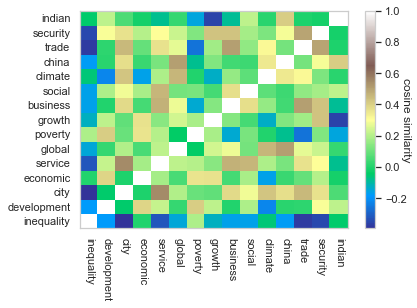

In [351]:
Doc2Vec(nowDF8, 'topic8', keywords8)

/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


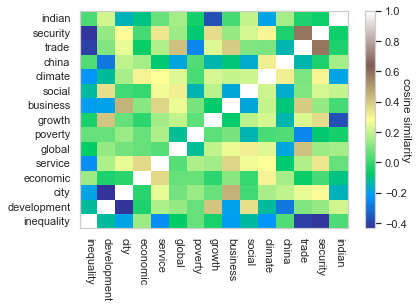

In [352]:
Doc2Vec(nowDF8_p1, 'topic8_p1', keywords8)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


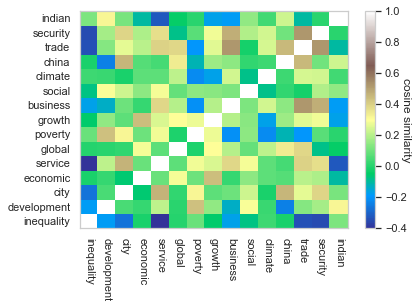

In [353]:
Doc2Vec(nowDF8_p2, 'topic8_p2', keywords8)


/Applications/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


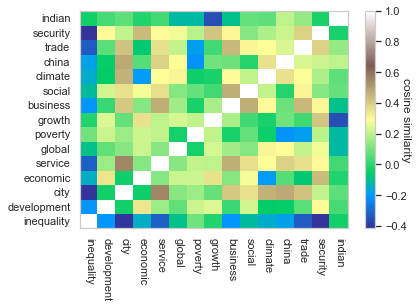

In [354]:
Doc2Vec(nowDF8_p3, 'topic8_p3', keywords8)


# Name-Entity

In [182]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [183]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [184]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [188]:
def entity_count(nowDF1, par_kind):
    OrgCounts = {}
    for entry in nowDF1['classified_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if kind == par_kind:
                    #continue
                    if ent in OrgCounts:
                        OrgCounts[ent] += 1
                    else:
                        OrgCounts[ent] = 1
    sortedOrgObj = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedOrgObj[:20]

def all_entity_count(nowDF1):
    entity_df = pd.DataFrame()
    # all entity
    entityCounts = {}
    for entry in nowDF1['classified_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if ent in entityCounts:
                    entityCounts[ent] += 1
                else:
                    entityCounts[ent] = 1
    sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
    allDF = pd.DataFrame(sortedEntities[:20], columns=['Entity','number'])
    # Organizations
    orgDF = pd.DataFrame(entity_count(nowDF1, par_kind = "ORG"), columns=['ORG','number'])
    # Geopolitical Entity
    gpeDF = pd.DataFrame(entity_count(nowDF1, par_kind = "GPE"), columns=['GPE','number'])
    # Nation, Race
    norpDF = pd.DataFrame(entity_count(nowDF1, par_kind = "NORP"), columns=['NORP','number'])
    # Law
    lawDF = pd.DataFrame(entity_count(nowDF1, par_kind = "LAW"), columns=['LAW','number'])
    return allDF, orgDF, gpeDF, norpDF, lawDF

In [189]:
import spacy
nlp = spacy.load("en")

Below, prepare the tokenize processing

In [190]:
# done
nowDF0['sentences'] = nowDF0['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF0['classified_sents'] = nowDF0['sentences'].apply(lambda x: tag_sents_ner(x))

In [216]:
nowDF1['sentences'] = nowDF1['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF1['classified_sents'] = nowDF1['sentences'].apply(lambda x: tag_sents_ner(x))


In [217]:
nowDF2['sentences'] = nowDF2['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF2['classified_sents'] = nowDF2['sentences'].apply(lambda x: tag_sents_ner(x))


In [218]:
nowDF3['sentences'] = nowDF3['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF3['classified_sents'] = nowDF3['sentences'].apply(lambda x: tag_sents_ner(x))


In [219]:
nowDF4['sentences'] = nowDF4['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF4['classified_sents'] = nowDF4['sentences'].apply(lambda x: tag_sents_ner(x))

nowDF5['sentences'] = nowDF5['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF5['classified_sents'] = nowDF5['sentences'].apply(lambda x: tag_sents_ner(x))

nowDF6['sentences'] = nowDF6['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF6['classified_sents'] = nowDF6['sentences'].apply(lambda x: tag_sents_ner(x))


KeyboardInterrupt: 

In [243]:
# Fix the Error: [E088] Text of length 1084230 exceeds maximum of 1000000. 
nowDF7=nowDF7[nowDF7.text.apply(lambda x: len(x)<=1000000)]
nowDF7['sentences'] = nowDF7['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF7['classified_sents'] = nowDF7['sentences'].apply(lambda x: tag_sents_ner(x))


In [244]:
nowDF8=nowDF8[nowDF8.text.apply(lambda x: len(x)<=1000000)]
nowDF8['sentences'] = nowDF8['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in sent_tokenize(x)])
nowDF8['classified_sents'] = nowDF8['sentences'].apply(lambda x: tag_sents_ner(x))


In [190]:
# Entity plots for DF0
def entity_plot(nowDF0, name):
    entities1=all_entity_count(nowDF0)

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="number", y= "Entity", data=entities1[0])
    ax.set_title('ALL Entities in topic'+str(name))
    ax.get_figure().savefig("entity_"+str(name)+"_ALL.jpg")

    ax = sns.barplot(x="number", y= "ORG", data=entities1[1])
    ax.set_title('ORG Entities in topic'+str(name))
    ax.get_figure().savefig("entity_"+str(name)+"_ORG.jpg")

    ax = sns.barplot(x="number", y= "GPE", data=entities1[2])
    ax.set_title('GPE Entities in topic'+str(name))
    ax.get_figure().savefig("entity_"+str(name)+"_GPE.jpg")

    ax = sns.barplot(x="number", y= "NORP", data=entities1[3])
    ax.set_title('NORP Entities in topic'+str(name))
    ax.get_figure().savefig("entity_"+str(name)+"_NORP.jpg")

    ax = sns.barplot(x="number", y= "LAW", data=entities1[4])
    ax.set_title('LAW Entities in topic'+str(name))
    ax.get_figure().savefig("entity_"+str(name)+"_LAW.jpg")


In [191]:
entity_plot(nowDF0, 0)

KeyError: 'classified_sents'

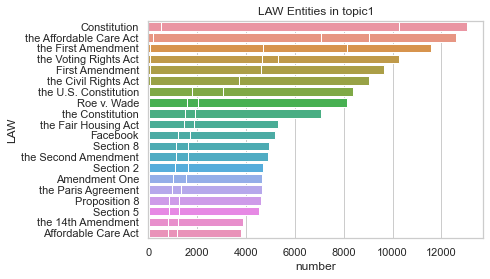

In [246]:
entity_plot(nowDF1, 1)

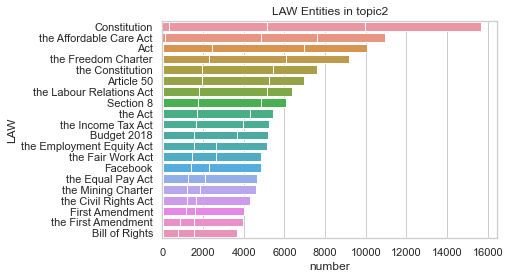

In [245]:
entity_plot(nowDF2, 2)

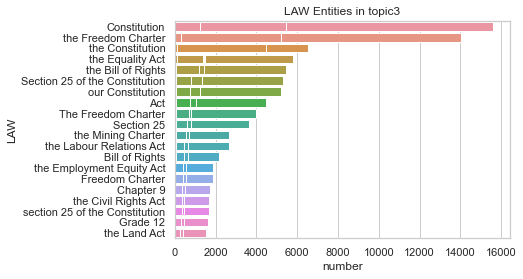

In [247]:
entity_plot(nowDF3, 3)

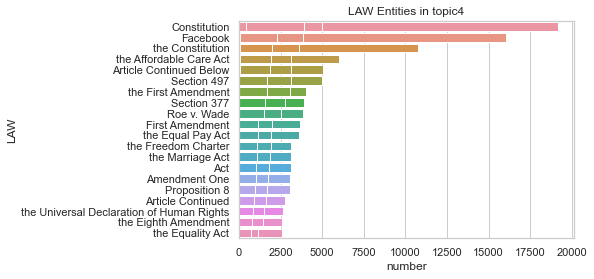

In [248]:
entity_plot(nowDF4, 4)

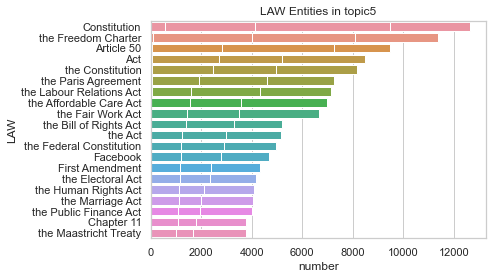

In [249]:
entity_plot(nowDF5, 5)

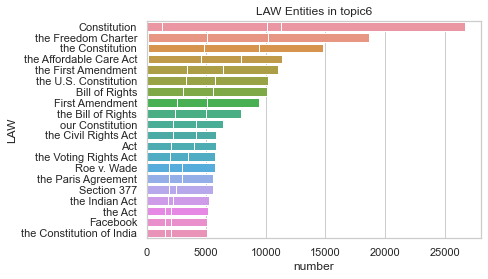

In [250]:
entity_plot(nowDF6, 6)

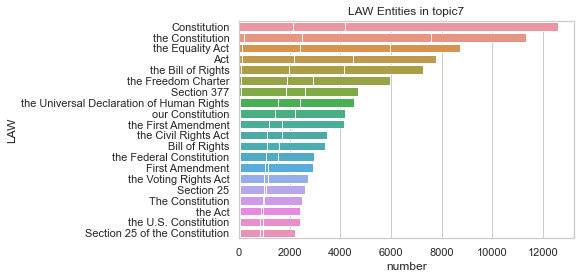

In [251]:
entity_plot(nowDF7, 7)

In [1]:
entity_plot(nowDF8, 8)

NameError: name 'entity_plot' is not defined

# Word Cloud

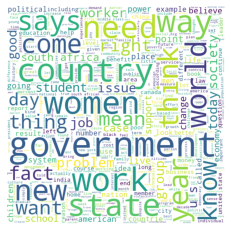

In [29]:
# Define some meaningless words to remove
l_remove = ['said','year','time','people']
# Generate list of new words
delete = nowDF_p1['normalized_words'].sum()
new_words = [word for word in delete if word not in l_remove]
# word cloud
wc1 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(new_words))
plt.imshow(wc1)
plt.axis("off")
plt.savefig("wordcloud_DF1.pdf", format = 'pdf')

(-0.5, 499.5, 499.5, -0.5)

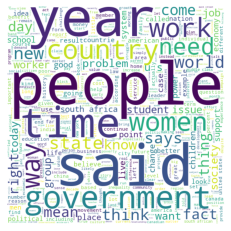

In [20]:
# wordcloud 1

wc1 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(nowDF_p1['normalized_words'].sum()))
plt.imshow(wc1)
plt.axis("off")
#plt.savefig("wordcloud_DF1.pdf", format = 'pdf')

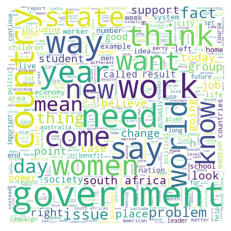

In [30]:
# Define some meaningless words to remove
l_remove = ['said','year','time','people']
# Generate list of new words
delete = nowDF_p2['normalized_words'].sum()
new_words = [word for word in delete if word not in l_remove]
# word cloud
wc2 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(new_words))
plt.imshow(wc2)
plt.axis("off")
plt.savefig("wordcloud_DF2.pdf", format = 'pdf')


(-0.5, 499.5, 499.5, -0.5)

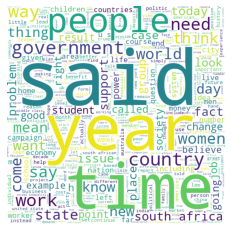

In [21]:
# wordcloud 2

wc2 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(nowDF_p2['normalized_words'].sum()))
plt.imshow(wc2)
plt.axis("off")
#plt.savefig("wordcloud_DF1.pdf", format = 'pdf')

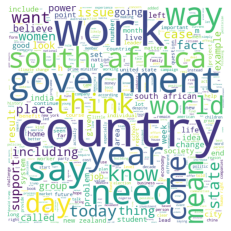

In [31]:
# Define some meaningless words to remove
l_remove = ['said','year','time','people']
# Generate list of new words
delete = nowDF_p3['normalized_words'].sum()
new_words = [word for word in delete if word not in l_remove]
# word cloud
wc3 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(new_words))
plt.imshow(wc3)
plt.axis("off")
plt.savefig("wordcloud_DF3.pdf", format = 'pdf')

In [22]:
# wordcloud 3

w3 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(nowDF_p3['normalized_words'].sum()))
plt.imshow(wc3)
plt.axis("off")
#plt.savefig("wordcloud_DF1.pdf", format = 'pdf')

KeyboardInterrupt: 

In [57]:
topic_name = 'topic8'
nowDF8 = pd.read_table('../data/inequality_topic/'+ topic_name + '_text.csv' ,header=0, encoding='gb2312', sep=',') 


In [64]:
nowDF8['text'][5]

' I first knew Mozambique through close contact in Dar es Salaam with FRELIMO in the early and difficult years -- the 1960s and the first-half of 1970s -- of its armed liberation struggle . Then Mozambique was seeking both to unite itself and to find political and military purchase against an intransigent and arrogant Portuguese colonialism . And FRELIMO -- under the leadership of , first , Eduardo Mondlane ( to be assassinated by the Portuguese ) and , after him , of Samora Machel -- did indeed manage , by 1975 , to lead the country to victory . Along the way , FRELIMO succeeded in liberating zones in Mozambique adjacent to its rear bases in Tanzania and Zambia where it built a new social infrastructure of agricultural coops , schools and health services . Equally important , it forged an impressive corps of politically conscious and disciplined leadership cadres ( see Caba ? o , 2001 and 2009 ) .   Then , in the very first years of Mozambique \'s independence , FRELIMO @ @ @ @ @ @ @ 

# W2V similiar words

In [192]:
nowW2V4 = gensim.models.word2vec.Word2Vec(nowDF4['normalized_sents'].sum())

In [196]:
nowW2V4_1 = gensim.models.word2vec.Word2Vec(nowDF4_p1['normalized_sents'].sum())
nowW2V4_2 = gensim.models.word2vec.Word2Vec(nowDF4_p2['normalized_sents'].sum())
nowW2V4_3 = gensim.models.word2vec.Word2Vec(nowDF4_p3['normalized_sents'].sum())


In [223]:
nowW2V4.most_similar(positive=['man', 'woman'], negative=['success'])


[('male', 0.5058771371841431),
 ('assertive', 0.44832730293273926),
 ('equally', 0.44154906272888184),
 ('demean', 0.44154074788093567),
 ('girl', 0.4390455186367035),
 ('reluctant', 0.43626290559768677),
 ('subordinate', 0.43576163053512573),
 ('person', 0.4342691898345947),
 ('people', 0.4253735840320587),
 ('heterosexual', 0.42455780506134033)]

In [221]:
nowW2V4_1.most_similar(positive=['man', 'woman'], negative=['work'])


[('girl', 0.5484926700592041),
 ('boy', 0.5180959701538086),
 ('male', 0.5127999186515808),
 ('gang', 0.4951897859573364),
 ('dreamer', 0.49282968044281006),
 ('rape', 0.47225815057754517),
 ('age', 0.46518561244010925),
 ('adult', 0.4649980664253235),
 ('black', 0.46483370661735535),
 ('sexually', 0.4639148712158203)]

In [219]:
nowW2V4_2.most_similar(positive=['man', 'woman'], negative=['work'])


[('girl', 0.6001318097114563),
 ('boy', 0.5553656816482544),
 ('sexually', 0.456764280796051),
 ('hijab', 0.4396696984767914),
 ('equally', 0.4341218173503876),
 ('australians', 0.4333188235759735),
 ('disrespect', 0.42467570304870605),
 ('heterosexual', 0.42407506704330444),
 ('rape', 0.4146937131881714),
 ('body', 0.4131571054458618)]

In [218]:
nowW2V4_3.most_similar(positive=['man', 'woman'], negative=['work'])


[('girl', 0.5416151285171509),
 ('boy', 0.522918164730072),
 ('lesbian', 0.4578222930431366),
 ('male', 0.44019028544425964),
 ('australians', 0.4397295117378235),
 ('inferior', 0.4250599443912506),
 ('respondent', 0.40464144945144653),
 ('person', 0.40291082859039307),
 ('perpetrator', 0.40241608023643494),
 ('lesser', 0.39427509903907776)]

Education

In [224]:
nowW2V0 = gensim.models.word2vec.Word2Vec(nowDF0['normalized_sents'].sum())

In [225]:
nowW2V0_1 = gensim.models.word2vec.Word2Vec(nowDF0_p1['normalized_sents'].sum())
nowW2V0_2 = gensim.models.word2vec.Word2Vec(nowDF0_p2['normalized_sents'].sum())
nowW2V0_3 = gensim.models.word2vec.Word2Vec(nowDF0_p3['normalized_sents'].sum())


In [249]:
nowW2V0.most_similar(positive=['male', 'female'], negative=['education'])


[('heterosexual', 0.5876309871673584),
 ('outnumber', 0.5646052360534668),
 ('cisgender', 0.5595731735229492),
 ('foeticide', 0.5556224584579468),
 ('genital', 0.5513761639595032),
 ('caucasian', 0.5501993894577026),
 ('mutilation', 0.5479801893234253),
 ('alpha', 0.5458617806434631),
 ('circumcision', 0.5363444685935974),
 ('masculine', 0.5261819958686829)]

In [254]:
nowW2V0_1.most_similar(positive=['male', 'female'], negative=['research'])


[('boy', 0.7751871347427368),
 ('counterpart', 0.7258799076080322),
 ('likely', 0.7256777286529541),
 ('teen', 0.7179824113845825),
 ('marry', 0.6935620307922363),
 ('25-', 0.6864925026893616),
 ('man', 0.6864129900932312),
 ('sex', 0.681887149810791),
 ('drop', 0.6781476140022278),
 ('white', 0.6757450103759766)]

In [256]:
nowW2V0_2.most_similar(positive=['male', 'female'], negative=['family'])


[('representation', 0.6820112466812134),
 ('circumcision', 0.6691261529922485),
 ('stem', 0.6654722094535828),
 ('dominate', 0.5908211469650269),
 ('minor', 0.5847007036209106),
 ('underrepresent', 0.5733144283294678),
 ('genital', 0.5717629194259644),
 ('counterpart', 0.5692911744117737),
 ('professorship', 0.569089949131012),
 ('outnumber', 0.5629853010177612)]

In [252]:
nowW2V0_3.most_similar(positive=['male', 'female'], negative=['family'])


[('genital', 0.6606130599975586),
 ('mutilation', 0.6544889211654663),
 ('dominate', 0.6273206472396851),
 ('stem', 0.6197359561920166),
 ('circumcision', 0.6030440330505371),
 ('traditionally', 0.5865814685821533),
 ('underrepresentation', 0.5661189556121826),
 ('counterpart', 0.5649133920669556),
 ('underrepresent', 0.5621849298477173),
 ('cultism', 0.5446569919586182)]